<a href="https://colab.research.google.com/github/Joey2441-spec/tensorflow_doc/blob/main/Audio_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Audio recognition of numbers
Using Audio MNIST, 30000 audio samples of spoken digits (0-9) of 60 different speakers for 500 audio samples per speaker and each speaker has their own directory. So we would need to shuffle and create train and test sets.

https://github.com/soerenab/AudioMNIST

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Get Audio MNIST from github

In [ ]:
# Clone repo
!git clone https://github.com/soerenab/AudioMNIST audio_mnist

#Append all audio to a list

In [54]:
import os

base_url = '/content/audio_mnist/data'
wav_paths = []

# grab the data of 10 speakers so 5000 samples
# development use only 1 speaker so 500 samples
for i in sorted(os.listdir(base_url)[:2]):
  try:
    for audio in sorted(os.listdir(os.path.join(base_url, i))):
      wav_paths.append(os.path.join(base_url, i, audio))
  except Exception as e:
    pass


#Visualize the audio

In [ ]:
import librosa
from IPython.display import Audio

audio, sr = librosa.load(wav_paths[0])
audio = librosa.util.normalize(audio) # get it between -1 - 1
audiowgt = Audio(data=audio, rate=sr)
display(audiowgt)
librosa.display.waveshow(audio, sr=sr)

#Resample audio to be a fixed length of 1 sec based on sampling rate (sampling per second)

In [70]:
def get_mfcc(path,aug=False):
    '''Get mel-frequency cepstral coefficients for the audio frame

    Args:
    path: Audio File Path
    snr: Signal to noise value >1 , <100
    aug: bool , whether to return augumented mfccs'''
    audio,sr = load_audio(path)
    audio = librosa.util.normalize(audio)
    mfcc = librosa.feature.mfcc(y=audio,sr=sr,n_mfcc=13,hop_length=512,n_fft=2048)
    if aug:
        aug_mfcc = librosa.feature.mfcc(y=aug_audio,sr=sr,n_mfcc=13,hop_length=512,n_fft=2048)
        return [np.expand_dims(mfcc,axis=-1),np.expand_dims(aug_mfcc,axis=-1)]
    return np.expand_dims(mfcc,axis=-1)

#Feature extraction of, Mel Spectrogram, Spectrogram, Periodogram, MFCC

In [63]:
import numpy as np
#Mel spectrogram
def get_mfcc(path):
  audio, sr = load_audio(path)
  audio = librosa.util.normalize(audio)
  mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13, hop_length=512, n_fft=2048)

  return np.expand_dims(mfcc, axis=-1)



In [74]:
X = []
Y = []
k = 0

for i in wav_paths:
  k += 1
  display(k)
  # /content/audio_mnist/data/01/0_01_0.wav
  clss = i.split('/')[-1].split('.')[0].split('_')[0] # holds the correct classification for an audio sample
  mfcs = get_mfcc(i)

  # each sample has a size of (13, 44, 1)
  X.append(mfcs)
  Y.append(int(clss))
  clear_output(wait=True)



1000

Get Train, Test datasets

In [75]:
from sklearn.model_selection import train_test_split

# 20% of data is used to test
x_train, x_test, y_train, y_test = train_test_split(np.asarray(X), np.asarray(Y), test_size=0.2, random_state=42)



In [86]:
import matplotlib.pyplot as plt

'''
plot the loss graph, accuracy graph from both training and testing,
optionally can save the model to a file

history : the return of calling .fit
epochs : the number of training iterations
'''
def plot(history, epochs, model=None, save=False):
  hist = history.history
  plt.subplot(1,2,1)
  plt.title('Loss Graph')
  plt.plot(range(epochs), hist['loss'], color='r', label='Loss')
  # val_loss = validation loss
  plt.plot(range(epochs), hist['val_loss'], color='g', label="val_loss")
  plt.legend()
  plt.tight_layout()
  plt.subplot(1,2,2)
  plt.title('Accuracy Graph')
  plt.plot(range(epochs),hist['accuracy'],color='r',label='accuracy')
  plt.plot(range(epochs),hist['val_accuracy'],color='g',label='Val_accuracy')
  plt.legend()
  plt.tight_layout()
  plt.suptitle('Loss-Accuracy Plot')
  l_low , a_max = min(hist['val_loss']) , max(hist['val_accuracy'])
  if save and model != None:
    plt.savefig(f'./progress/history plot/lmin{l_low}_amin{a_max}.png')
    model.save(f'./progress/model/lmin{l_low}_amin{a_max}.h5')
    print('Plot and Model Saved')

In [ ]:
x_train[1].shape

#Create the Model

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalMaxPool2D
from tensorflow.keras import Sequential
def build_model():
  model = Sequential()
  # valid = will shrink the output space a little and outer feature are less pronounced.
  # relu activation will be from 0-1
  model.add(Conv2D(64, (3), input_shape=x_train[0].shape, padding='valid', activation='relu'))
  model.add(Conv2D(64, (3), padding='valid', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3), strides=(2), padding='same'))
  model.add(Conv2D(128, (3), padding='valid', activation='relu'))
  model.add(GlobalMaxPool2D())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(10, activation='softmax'))
  return model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model.summary()




#Train model

In [81]:
es_cb = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [ ]:
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test,y_test), callbacks=[es_cb])


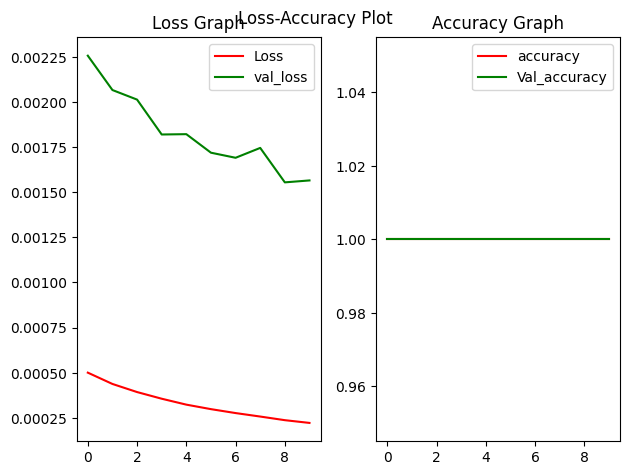

In [90]:
plot(history,len(history.history['val_loss']))

In [ ]:
pred = model.predict(x_train)

In [92]:
preds = [np.argmax(i) for i in pred]

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test,preds))

In [105]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
cfm = confusion_matrix(y_test,preds)
sns.heatmap(cfm,annot=True,fmt='d')
plt.title('Confusion Matrix')
plt.show()

# Using the trained model

In [126]:
import os

base_url = '/content/audio_mnist/data'
wav_paths = []

# grab the data of 10 speakers so 5000 samples
# development use only 1 speaker so 500 samples
for i in sorted(os.listdir(base_url)[13:14]):
  try:
    for audio in sorted(os.listdir(os.path.join(base_url, i))):
      wav_paths.append(os.path.join(base_url, i, audio))
  except Exception as e:
    pass

In [ ]:
X = []
Y = []
k = 0

for i in wav_paths:
  k += 1
  display(k)
  # /content/audio_mnist/data/01/0_01_0.wav
  clss = i.split('/')[-1].split('.')[0].split('_')[0] # holds the correct classification for an audio sample
  mfcs = get_mfcc(i)

  # each sample has a size of (13, 44, 1)
  X.append(mfcs)
  Y.append(int(clss))
  clear_output(wait=True)


In [ ]:
a = 40
b = 200
X = np.asarray(X)
ans = Y[a:b]


prediction = model.predict(X[a:b])
print("Pred ......... Label")
for i in range(b - a):
  pred = np.argmax(prediction[i])
  label = ans[i]
  print(f"{pred}{label:20}")


